import libraries and read data

In [1]:
#!pip uninstall eodal -y
#!pip install git+https://github.com/lukasValentin/eodal.git@landsat-dev

In [2]:
# Import necessary libraries
from pathlib import Path
from matplotlib import pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from shapely.geometry import Point
from sklearn.mixture import GaussianMixture

# Print scikit-learn version
print("Version of scikit-learn: " + sklearn.__version__)

# Import EOdal libraries
import eodal
from eodal.core.band import Band
from eodal.core.raster import RasterCollection


# Print EOdal version
print("Version of EOdal: " + eodal.__version__)


Version of scikit-learn: 1.2.2
Version of EOdal: 0.2.1


In [3]:
year = 2021

In [15]:
#read tif from disk:
fpath_raster = Path('S:\MSc_23_TimckeFinn\data\EOdal\landsat_median_composite_' + str(year) + '.tif')

#initialize a RasterCollection from the .tif file
composite = RasterCollection.from_multi_band_raster(fpath_raster=fpath_raster, band_aliases = ["blue", "green", "red", "nir_1", "swir"])

#calculate some SI
composite.calc_si('NDVI', inplace = True)
composite.calc_si('EVI', inplace = True)

#show RasterCollection
composite

EOdal RasterCollection
----------------------
# Bands:    7
Band names:    blue_median, green_median, red_median, nir08_median, swir16_median, NDVI, EVI
Band aliases:    blue, green, red, nir_1, swir, ndvi, evi

Text(0.5, 1.0, 'NDVI')

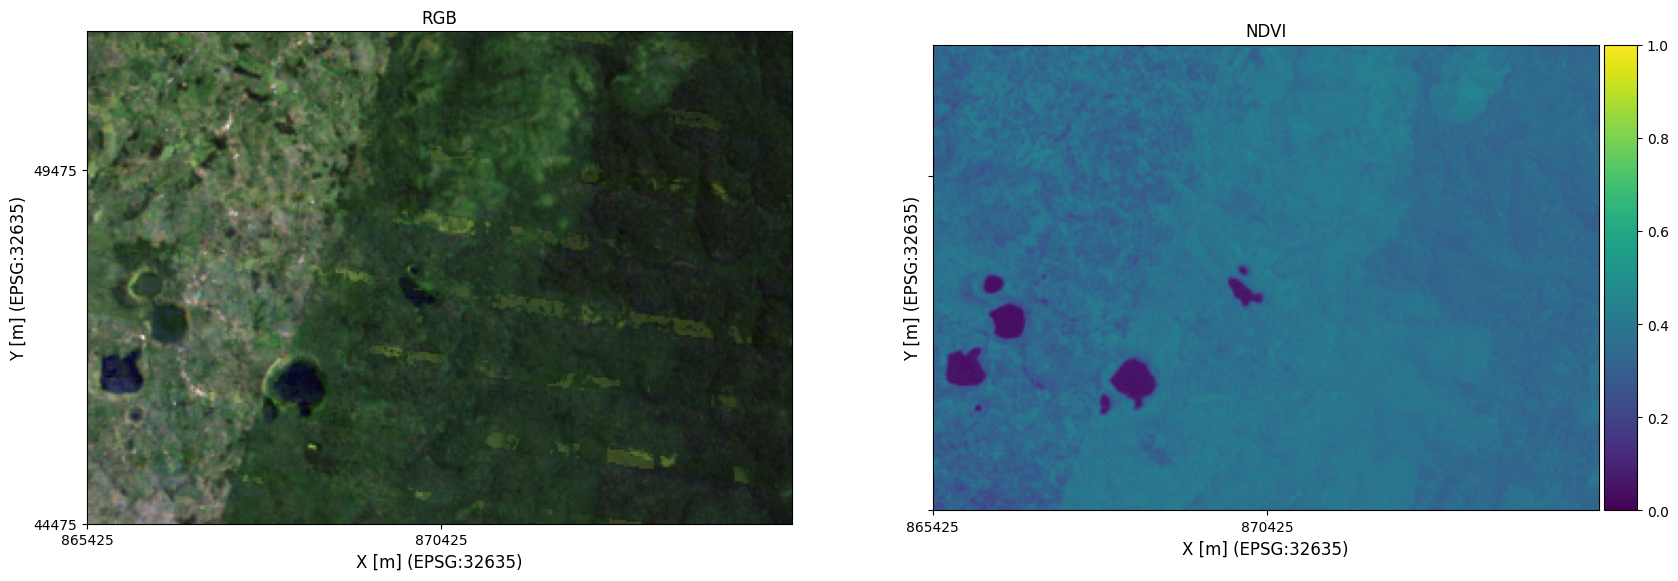

In [5]:
#Plot RGB and NDVI
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
axs[0].set_title("RGB")

composite.plot_band("NDVI", colormap="viridis", vmin=0, vmax=1, ax=axs[1])
axs[1].set_title("NDVI")

In [6]:
# Create a DataFrame from the RasterCollection
gdf = composite.to_dataframe()

# # Extract x and y coordinates into new columns
gdf['x_coordinate'] = gdf['geometry'].apply(lambda point: Point(point).x)
gdf['y_coordinate'] = gdf['geometry'].apply(lambda point: Point(point).y)

display(gdf)


,geometry,blue_median,green_median,red_median,nir08_median,swir16_median,NDVI,EVI,x_coordinate,y_coordinate
0,POINT (865425.000 51435.000),0.081505,0.091105,0.086015,0.182925,0.124215,0.360341,0.222735,865425.0,51435.0
1,POINT (865425.000 51405.000),0.082445,0.090685,0.086735,0.177925,0.118510,0.344555,0.211088,865425.0,51405.0
2,POINT (865425.000 51375.000),0.083210,0.091405,0.087770,0.170495,0.124580,0.320311,0.192735,865425.0,51375.0
3,POINT (865425.000 51345.000),0.084310,0.094790,0.091145,0.166120,0.137765,0.291431,0.173446,865425.0,51345.0
4,POINT (865425.000 51315.000),0.082410,0.093210,0.090380,0.162820,0.134480,0.286098,0.166602,865425.0,51315.0
...,...,...,...,...,...,...,...,...,...,...
77019,POINT (875355.000 44625.000),0.079610,0.085670,0.081410,0.158330,0.113870,0.320848,0.183193,875355.0,44625.0
77020,POINT (875355.000 44595.000),0.079350,0.084300,0.080400,0.161180,0.113240,0.334382,0.192617,875355.0,44595.0
77021,POINT (875355.000 44565.000),0.078690,0.084050,0.079600,0.166230,0.113480,0.352398,0.205546,875355.0,44565.0
77022,POINT (875355.000 44535.000),0.078720,0.084040,0.079690,0.162880,0.111410,0.342953,0.197955,875355.0,44535.0


Use K-means for Clustering:

In [7]:
# Select all columns except the first one (geometry is non-numeric)
selected_columns = ['blue_median', 'green_median', 'red_median', 'nir08_median', 'swir16_median', 'NDVI', 'EVI']

#set the desired number of clusters
n_clusters = 8

# Apply KMeans to the selected columns of the DataFrame
model = KMeans(n_clusters = n_clusters, n_init=10, random_state = 42) 

#fit the model to the data
model.fit(gdf[selected_columns])

# Get the cluster labels
labels = model.labels_

# Add the cluster labels to the DataFrame and show it
gdf[str(KMeans.__name__ + "_cluster")] = labels
gdf
# create new band instance from a column in GeoDataFrame
cluster_band = Band.from_vector(vector_features = gdf,
                                 band_name_src = "KMeans_cluster",
                                 geo_info = composite['blue'].geo_info,
                                 band_name_dst = "KMeans_cluster")

#add column cluster_label as a new Band into the RasterCollection composite
composite.add_band(cluster_band)

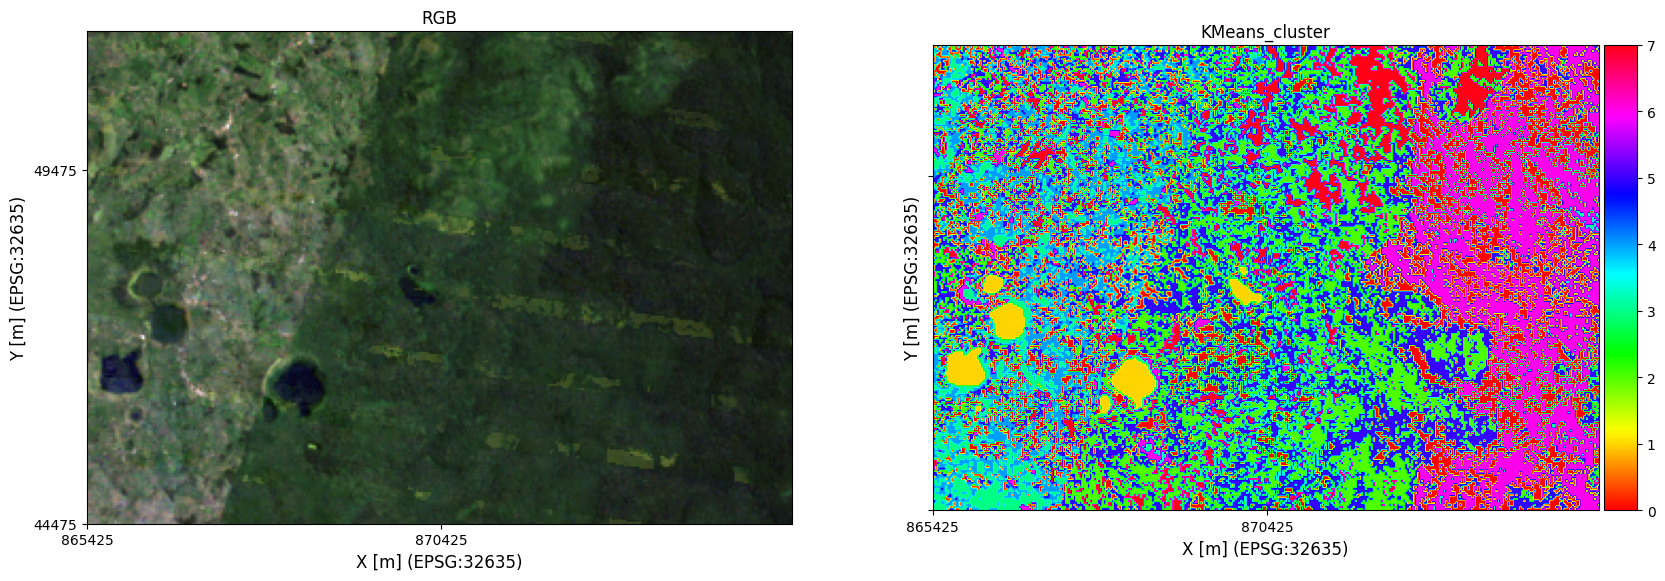

In [8]:
from clusteringfunctions import plot_cluster


plot_cluster(composite, cluster_band = "KMeans_cluster")

Use Gaussian Mixture Models for Clustering:

Text(0.5, 1.0, 'GMM cluster')

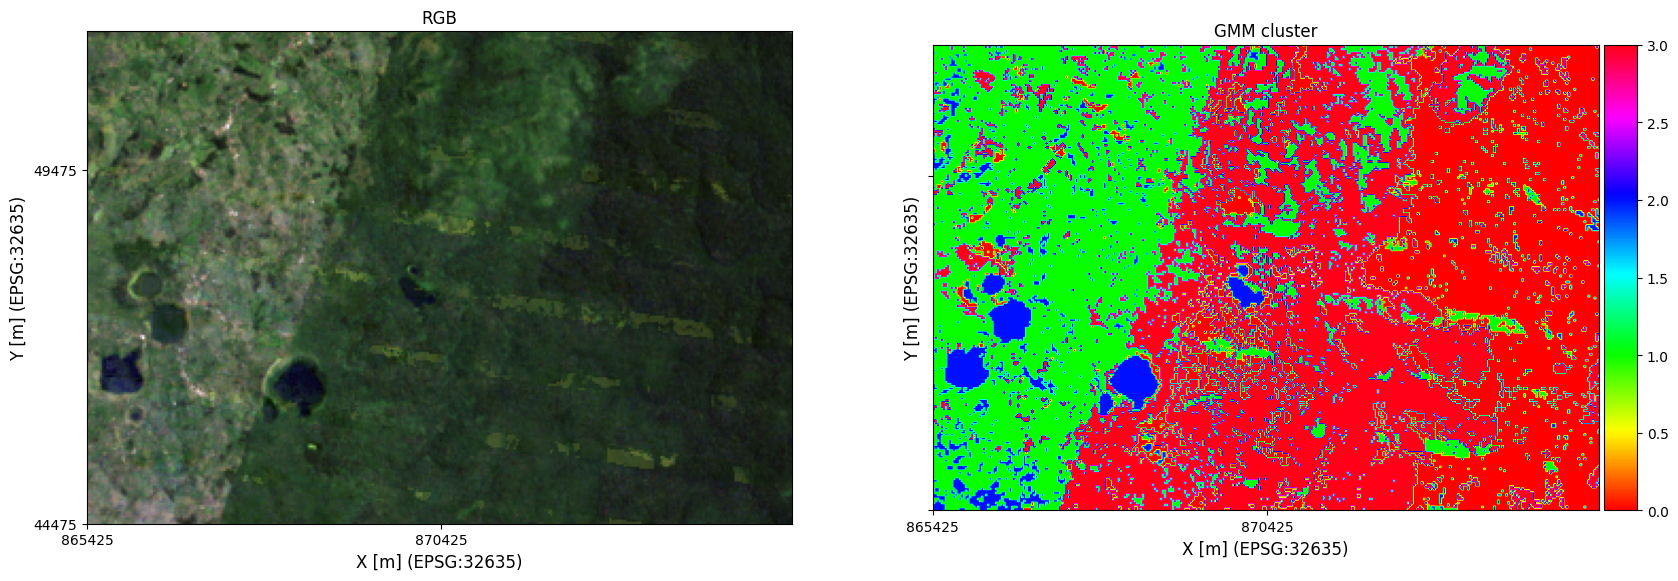

In [9]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from geopandas import GeoDataFrame

# Select all columns except the first one (geometry is non-numeric)
selected_columns = ['blue_median', 'green_median', 'red_median', 'nir08_median', 'swir16_median', 'NDVI', 'EVI']

#set the desired number of clusters
n_clusters = 4

# Step 1: Extract numerical features from GeoDataFrame
feature_matrix = gdf[selected_columns].values

# Step 2: Normalize the feature matrix
scaler = StandardScaler()
normalized_features = scaler.fit_transform(feature_matrix)

# Step 4: Apply Gaussian Mixture Models
num_clusters = 7  # Specify the desired number of clusters
gmm = GaussianMixture(n_components=n_clusters, random_state=0)

gmm.fit(normalized_features)

# Step 5: Assign cluster labels
GMM_cluster = gmm.predict(normalized_features)

# Step 6: Assign cluster labels to GeoDataFrame
gdf['GMM_cluster'] = GMM_cluster

# add column cluster_mean_shift as a new Band into the RasterCollection composite
GMM_cluster = Band.from_vector(vector_features = gdf,
                                 band_name_src = 'GMM_cluster',
                                 geo_info = composite['blue'].geo_info,
                                 band_name_dst = 'GMM_cluster')

composite.add_band(GMM_cluster)

#Plot RGB and Label
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
axs[0].set_title("RGB")

composite.plot_band("GMM_cluster", colormap="hsv", ax=axs[1])
axs[1].set_title("GMM cluster")

Use MeanShift for Clustering:

In [13]:
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler

# Step 1: Extract numerical features from GeoDataFrame
numerical_features = ['NDVI']#, 'x_coordinate', 'y_coordinate']  # Replace with your desired feature names
feature_matrix = gdf[numerical_features].values

# Step 2: Normalize the feature matrix
scaler = StandardScaler()
normalized_features = scaler.fit_transform(feature_matrix)

# Step 4: Apply MeanShift algorithm
bandwidth = 8  # Adjust the bandwidth as per your data
ms = MeanShift()
ms.fit(normalized_features)

# Step 5: Assign cluster labels
cluster_labels = ms.labels_

# Step 6: Assign cluster labels to GeoDataFrame
gdf['MeanShift_cluster'] = cluster_labels

# add column cluster_mean_shift as a new Band into the RasterCollection composite
MeanShift_cluster = Band.from_vector(vector_features = gdf,
                                 band_name_src = 'MeanShift_cluster',
                                 geo_info = composite['blue'].geo_info,
                                 band_name_dst='MeanShift_cluster')

composite.add_band(MeanShift_cluster)

#Plot RGB and Label
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
axs[0].set_title("RGB")

composite.plot_band("MeanShift_cluster", colormap="hsv", ax=axs[1])
axs[1].set_title("Mean Shift clusters")

KeyboardInterrupt: 

In [ ]:
gdf

,geometry,blue_median,green_median,red_median,nir08_median,swir16_median,NDVI,EVI,x_coordinate,y_coordinate,KMeans_cluster,GMM_cluster
0,POINT (865425.000 51435.000),0.081505,0.091105,0.086015,0.182925,0.124215,0.360341,0.222735,865425.0,51435.0,5,1
1,POINT (865425.000 51405.000),0.082445,0.090685,0.086735,0.177925,0.118510,0.344555,0.211088,865425.0,51405.0,0,1
2,POINT (865425.000 51375.000),0.083210,0.091405,0.087770,0.170495,0.124580,0.320311,0.192735,865425.0,51375.0,4,1
3,POINT (865425.000 51345.000),0.084310,0.094790,0.091145,0.166120,0.137765,0.291431,0.173446,865425.0,51345.0,3,1
4,POINT (865425.000 51315.000),0.082410,0.093210,0.090380,0.162820,0.134480,0.286098,0.166602,865425.0,51315.0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
77019,POINT (875355.000 44625.000),0.079610,0.085670,0.081410,0.158330,0.113870,0.320848,0.183193,875355.0,44625.0,6,0
77020,POINT (875355.000 44595.000),0.079350,0.084300,0.080400,0.161180,0.113240,0.334382,0.192617,875355.0,44595.0,6,0
77021,POINT (875355.000 44565.000),0.078690,0.084050,0.079600,0.166230,0.113480,0.352398,0.205546,875355.0,44565.0,0,0
77022,POINT (875355.000 44535.000),0.078720,0.084040,0.079690,0.162880,0.111410,0.342953,0.197955,875355.0,44535.0,6,0
